# MODEL PERFORMANCE IMPROVEMENT WITH BATCH NORMALIZATION & SELF-REGULARIZATION

**_Experimenting with techniques that solves deep neural network (DNN) training related problems such as gradient vanishing/exploding and slow training._**

**List of Experiments:**

1. Build a vanila DNN with layers using **_He_ initialization** and the **_Swish_ activation** function. Add 20 hidden layers each with 100 neurons and an output layer with 10 neurons with **_softmax activation_**. Train the network using **_Nadam_ optimization** and **early stopping** on the CIFAR10 dataset.

2. Add **batch normalization** and compare the learning curves to check if it **converges faster** than before. Also, check if model **prediction performance improved** and if batch normalization **affected training speed**.

3. **[OPTIONAL]** Experiment if layers with **_SELU activation_** can **self-regulate** a neural network. 

## Imports Packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import time

import tensorflow as tf

import matplotlib.pyplot as plt

2025-11-21 05:33:24.025560: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 05:33:24.025894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 05:33:24.077283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 05:33:25.299520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Helpers

In [2]:
def build_model(
    input_shape: tuple,
    hidden_layers: list,
    output_layer,
    ):

    # Resets all the keras states
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Flatten())

    for hidden_layer in hidden_layers:
        model.add(hidden_layer)

    model.add(output_layer)

    return model

In [3]:
def train_model(model, x, y, optimizer, loss, metrics, batch_size=32, 
                epochs=1, callbacks=None, validation_data=None):

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    history = model.fit(
        x, y, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=validation_data)
    
    return history


## Data Ingestion & Preparation

In [4]:
# Loads the CIFAR10 dataset that contains 50,000 32x32-pixels color training images and 10,000 test images, 
# labeled over 10 categories. See more info at the CIFAR homepage https://www.cs.toronto.edu/~kriz/cifar.html.

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
print(f"Pixel value range in train set: [{X_train_full.min()} - {X_train_full.max()}]")
print(f"Pixel value range in test set: [{X_test.min()} - {X_test.max()}]")

Pixel value range in train set: [0 - 255]
Pixel value range in test set: [0 - 255]


In [6]:
# Extracts out validation set from the train set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=5000, random_state=42, stratify=y_train_full)

In [7]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (45000, 32, 32, 3), y_train shape: (45000, 1)
X_val shape: (5000, 32, 32, 3), y_val shape: (5000, 1)


Try executing the following command from terminal to watch live learning curve across all exprements.

`tensorboard --logdir=<logs_path> --port=6006 --bind_all`

## Experiment #1
**_Using better layer initialization, activation and optmization with early stopping_**

### Modeling

In [8]:
# Creates a list of 20 hidden layers each with 100 units, "swish" activation and "he_normal" as kernel initializer

hidden_layers = []
for _ in range(20):
    hidden_layers.append(tf.keras.layers.Dense(100, activation="swish", kernel_initializer="he_normal"))

# Also creates a dense layer as output with 10 units with "softmax" activation
output_layer = tf.keras.layers.Dense(10, activation="softmax")

In [9]:
# Builds the model specifying the shape of the input as a tuple, hidden layers and output layer

model1 = build_model(
    input_shape=(32, 32, 3),
    hidden_layers=hidden_layers,
    output_layer=output_layer
)

2025-11-21 05:36:19.224867: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
# [OPTIONAL] Prints the model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       307,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,210 (1.91 MB)

 Trainable params: 500,210 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [11]:
# Configures a list of callbacks 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("./models/cifar-10/checkpoints/cifar-10.weights.keras", save_best_only=True),
    tf.keras.callbacks.TensorBoard(f"./models/cifar-10/logs/run-{time.strftime("%Y.%m.%d_%H.%M.%S")}")
]

In [12]:
# Trains the model1 making a call to `train_model` passing model, train set with labels,
# `Nadam`optimzer with 5e-4 as learning_rate, "sparse_categorical_crossentropy" as loss,
# ["accuracy"] as metrics, 100 as epochs, callbacks and validation set with labels
history1 = train_model(model1,
                       X_train, y_train,
                       optimizer=tf.keras.optimizers.Nadam(5e-4),
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"],
                       epochs=100,
                       callbacks=callbacks,
                       validation_data=(X_val, y_val))

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.1986 - loss: 3.6180 - val_accuracy: 0.2470 - val_loss: 2.0555
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2703 - loss: 1.9766 - val_accuracy: 0.2742 - val_loss: 1.9582
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2936 - loss: 1.9272 - val_accuracy: 0.2850 - val_loss: 1.9226
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3087 - loss: 1.8927 - val_accuracy: 0.3058 - val_loss: 1.8796
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3222 - loss: 1.8668 - val_accuracy: 0.3100 - val_loss: 1.8989
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3263 - loss: 1.8543 - val_accuracy: 0.3210 - val_loss: 1.8718
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3398 - loss: 1.8222 - val_accuracy: 0.3448 - val_loss: 1.8104
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3452 - loss:

### Evaluating Performance

Text(0.5, 1.0, 'Train vs. Validation accuracy')

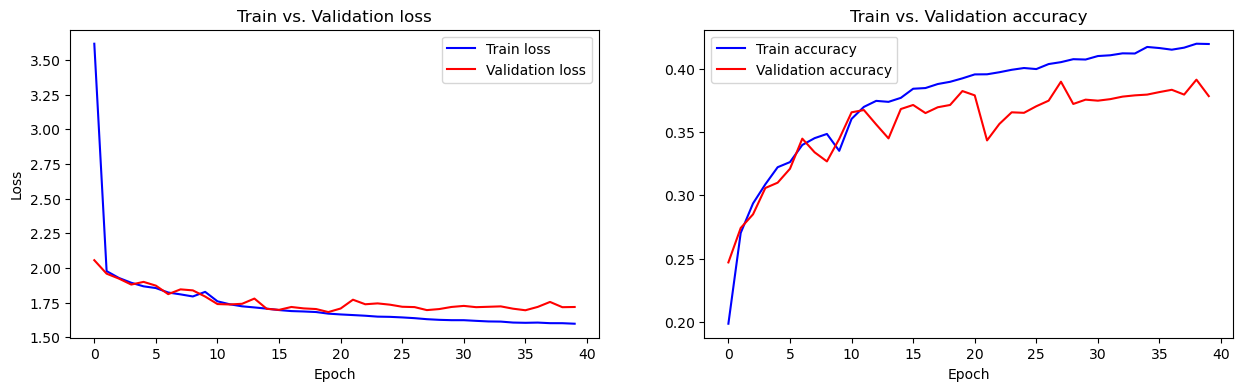

In [13]:
# Plots the learning curves

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))

ax1.plot(history1.history["loss"], "b-", label="Train loss")
ax1.plot(history1.history["val_loss"], "r-", label="Validation loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Train vs. Validation loss")

ax2.plot(history1.history["accuracy"], "b-", label="Train accuracy")
ax2.plot(history1.history["val_accuracy"], "r-", label="Validation accuracy")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.legend()
ax2.set_title("Train vs. Validation accuracy")

In [14]:
print(f"Lowest validation loss at epoch: {np.argmin(history1.history["val_loss"]) + 1}")

print(f"Highest validation accuracy of {max(history1.history["val_accuracy"])*100:.2f}% \
      reached at epoch {np.argmax(history1.history["val_accuracy"]) + 1}")


Lowest validation loss at epoch: 20
Highest validation accuracy of 39.14%       reached at epoch 39


In [15]:
# Tests prediction performance on test set
model1.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3800 - loss: 1.6881


[1.688058614730835, 0.3799999952316284]

Record the above results to compare the same from other next experiment.

## Experiment #2
**_Adding batch normalization for faster convergence and better model performance_**

### Modeling

In [16]:
# Creates a list of 20 pairs of hidden layers each with a batch normalization layer and dense
# layer with 100 units, "swish" activation and "he_normal" as kernel initializer

hidden_layers = []
for _ in range(20):
    hidden_layers.append(tf.keras.layers.BatchNormalization())
    hidden_layers.append(tf.keras.layers.Dense(100, activation="swish", kernel_initializer="he_normal"))

# Adds batch normalization just before the last dense output layer
hidden_layers.append(tf.keras.layers.BatchNormalization())

# Creates a dense layer as output with 10 units with "softmax" activation
output_layer = tf.keras.layers.Dense(10, activation="softmax")

In [17]:
# Builds the model specifying the shape of the input as a tuple, hidden layers and output layer
model2 = build_model(
    input_shape=(32, 32, 3),
    hidden_layers=hidden_layers,
    output_layer=output_layer
)

In [18]:
# [OPTIONAL] Prints the model summary
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3072)           │        12,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       307,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │             

 Total params: 520,498 (1.99 MB)

 Trainable params: 510,354 (1.95 MB)

 Non-trainable params: 10,144 (39.62 KB)

### Training the Model

In [19]:
# Configures the callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("./models/cifar-10/checkpoints/cifar-10.weights.keras", save_best_only=True),
    tf.keras.callbacks.TensorBoard(f"./models/cifar-10/logs/run-{time.strftime("%Y.%m.%d_%H.%M.%S")}")
]

In [20]:
# Trains the model2 making a call to `train_model` passing model2, train set with labels,
# `Nadam`optimizer with 5e-4 as learning_rate, "sparse_categorical_crossentropy" as loss,
# ["accuracy"] as metrics, 100 as epochs, callbacks and validation set with labels
history2 = train_model(model2,
                       X_train, y_train,
                       optimizer=tf.keras.optimizers.Nadam(5e-4),
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"],
                       epochs=100,
                       callbacks=callbacks,
                       validation_data=(X_val, y_val))

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.1846 - loss: 2.2561 - val_accuracy: 0.2732 - val_loss: 1.9824
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2919 - loss: 1.9482 - val_accuracy: 0.3360 - val_loss: 1.8099
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3341 - loss: 1.8372 - val_accuracy: 0.3752 - val_loss: 1.7373
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3690 - loss: 1.7591 - val_accuracy: 0.4092 - val_loss: 1.6517
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3988 - loss: 1.6886 - val_accuracy: 0.4250 - val_loss: 1.6181
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4229 - loss: 1.6299 - val_accuracy: 0.4452 - val_loss: 1.5731
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4438 - loss: 1.5726 - val_accuracy: 0.4414 - val_loss: 1.5721
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4661 

### Evaluating Performance

Text(0.5, 1.0, 'Train vs. Validation accuracy')

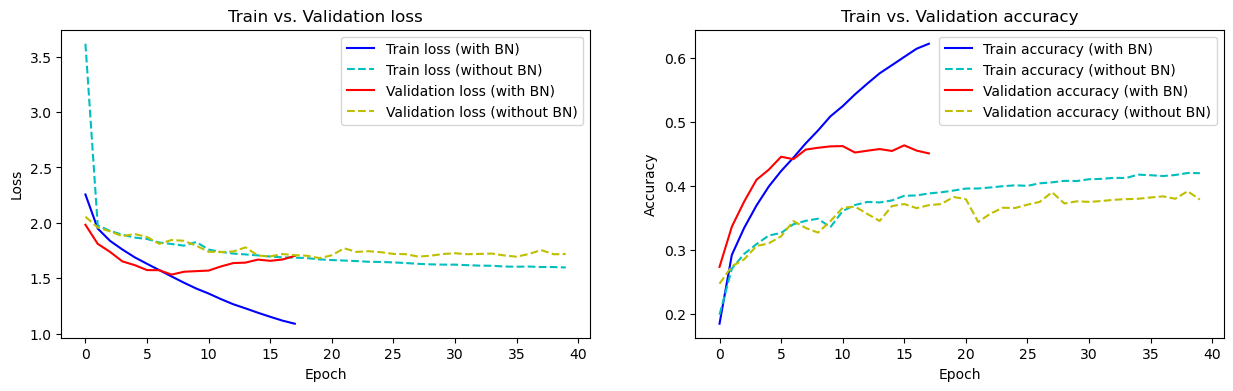

In [23]:
# Plots the learning curves

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))

ax1.plot(history2.history["loss"], "b-", label="Train loss (with BN)")
ax1.plot(history1.history["loss"], "c--", label="Train loss (without BN)")

ax1.plot(history2.history["val_loss"], "r-", label="Validation loss (with BN)")
ax1.plot(history1.history["val_loss"], "y--", label="Validation loss (without BN)")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Train vs. Validation loss")


ax2.plot(history2.history["accuracy"], "b-", label="Train accuracy (with BN)")
ax2.plot(history1.history["accuracy"], "c--", label="Train accuracy (without BN)")

ax2.plot(history2.history["val_accuracy"], "r-", label="Validation accuracy (with BN)")
ax2.plot(history1.history["val_accuracy"], "y--", label="Validation accuracy (without BN)")

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("Train vs. Validation accuracy")

In [24]:
print(f"Lowest validation loss at epoch: {np.argmin(history2.history["val_loss"]) + 1}")

print(f"Highest validation accuracy of {max(history2.history["val_accuracy"])*100:.2f}% \
      reached at epoch {np.argmax(history2.history["val_accuracy"]) + 1}")


Lowest validation loss at epoch: 8
Highest validation accuracy of 46.30%       reached at epoch 16


In [25]:
# Tests prediction performance on test set
model2.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4545 - loss: 1.5453


[1.5453494787216187, 0.4544999897480011]

**Observations:**

- The model with BN converged faster (at 8th epoch) with lowest validation error than the other model.

- The model with BN layers found to be better model scoring 45% accuracy score on test set compare to the other model that scored 40% on the same dataset.

- Compare the average time both the model took to complete each epoch. Due to the extra computations required for batch normalization, the model took around 12-15 seconds per epoch whereas it was only 7-8 seconds for the model without BN layers. But the extra time could be considered worthy to achieve faster convergence and to get a better model.